# DeepAR
## Why We Chose DeepAR for Bitcoin Fee Forecasting

Our exploratory data analysis revealed several key characteristics in the Bitcoin fee time series that informed our model selection:

### Key Observations from EDA

- **Strong temporal patterns**: The series exhibits clear intraday and multi-day cycles.
- **Volatility and sharp spikes**: Transaction fees fluctuate unpredictably with sudden, high-magnitude surges.
- **Multivariate dependencies**: Fee behavior is influenced by multiple covariates such as mempool congestion, difficulty adjustment, and market signals.
- **Lagged effects**: Both the target and covariates show meaningful dependencies on past values.

### Why DeepAR is a Good Fit

- **Probabilistic autoregressive modeling**: DeepAR models future values as a distribution conditioned on historical data, making it suitable for capturing uncertainty and variability.
- **Sequence-to-sequence RNN structure**: It naturally captures temporal dependencies and lagged effects, especially for high-frequency financial time series.
- **Handles multiple related time series**: DeepAR can leverage patterns across different fee types (e.g., fastestFee, hourFee, economyFee) to improve prediction accuracy.
- **Distributional output**: The model supports flexible likelihoods (e.g., Gaussian, LogNormal), making it adaptable to the right-skewed nature of fee data.
- **Scalable and generalizable**: Suitable for long training histories and aligned prediction horizons across series.

Given these factors, DeepAR offers a strong balance of flexibility, probabilistic forecasting, and temporal modeling capacity for our transaction fee prediction task.


## 1. Data Import, Transformation, and Preparation

This section prepares the dataset for training a DeepAR model. DeepAR requires a long-format time series with consistent time steps, encoded time features, and normalized inputs. We perform preprocessing, transformation, and scaling to ensure the model receives structured, normalized, and correctly segmented input.

In [335]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.tuner import Tuner

import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MultivariateNormalDistributionLoss, MultiHorizonMetric
from pytorch_forecasting.data import GroupNormalizer
import pytorch_forecasting as ptf

import os
import sys
from pathlib import Path
import pickle

# Add ../src to the Python module search path
src_path = Path("..") / "src"
sys.path.append(str(src_path.resolve()))



In [210]:
# Import raw Bitcoin mempool and fee data, clean, and resample it
from preprocess_raw_parquet import preprocess_raw_parquet
df = preprocess_raw_parquet("../data/raw/mar_5_may_12.parquet")  # Clean and structure raw input from .parquet
df.head()

,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,recommended_fee_minimumFee,...,mempool_fee_histogram_bin_70_75,mempool_fee_histogram_bin_75_80,mempool_fee_histogram_bin_80_85,mempool_fee_histogram_bin_85_90,mempool_fee_histogram_bin_90_95,mempool_fee_histogram_bin_95_100,mempool_fee_histogram_bin_100_150,mempool_fee_histogram_bin_150_200,mempool_fee_histogram_bin_200_250,mempool_fee_histogram_bin_250_300
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-05 02:00:00,2.170952e+06,997895.375000,793.000000,1.846754e+06,1.300111,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:15:00,1.801526e+06,997925.916667,2627.000000,3.407913e+06,2.473960,3.000000,2.666667,2.666667,2.666667,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:30:00,2.055350e+06,997965.916667,922.000000,1.855358e+06,1.355898,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:45:00,2.006800e+06,997970.083333,1296.666667,2.167251e+06,1.536092,2.333333,2.333333,2.333333,2.333333,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 03:00:00,1.773658e+06,997960.333333,2725.333333,3.462741e+06,2.467659,3.333333,3.000000,3.000000,3.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [211]:
# Transform the cleaned data for DeepAR modeling
from transform_fee_data_dl import transform_fee_data_dl
df = transform_fee_data_dl(df)  # Adds time encodings, reshapes to long format, assigns time_idx
df.head()

,timestamp,series_id,target,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,mempool_count,mempool_vsize,...,mempool_fee_histogram_bin_250_300,time_idx,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,minute_sin,minute_cos
0,2025-03-05 02:00:00,recommended_fee_economyFee,2.000000,2.170952e+06,997895.375000,793.000000,1.846754e+06,1.300111,7971.000000,4.809659e+07,...,0.0,0,0.500000,0.866025,0.974928,-0.222521,1.0,6.123234e-17,0.000000e+00,1.000000e+00
1,2025-03-05 02:15:00,recommended_fee_economyFee,2.666667,1.801526e+06,997925.916667,2627.000000,3.407913e+06,2.473960,9943.333333,4.946978e+07,...,0.0,1,0.500000,0.866025,0.974928,-0.222521,1.0,6.123234e-17,1.000000e+00,2.832769e-16
2,2025-03-05 02:30:00,recommended_fee_economyFee,2.000000,2.055350e+06,997965.916667,922.000000,1.855358e+06,1.355898,8189.333333,4.936482e+07,...,0.0,2,0.500000,0.866025,0.974928,-0.222521,1.0,6.123234e-17,5.665539e-16,-1.000000e+00
3,2025-03-05 02:45:00,recommended_fee_economyFee,2.333333,2.006800e+06,997970.083333,1296.666667,2.167251e+06,1.536092,8874.666667,5.061585e+07,...,0.0,3,0.500000,0.866025,0.974928,-0.222521,1.0,6.123234e-17,-1.000000e+00,-1.836970e-16
4,2025-03-05 03:00:00,recommended_fee_economyFee,3.000000,1.773658e+06,997960.333333,2725.333333,3.462741e+06,2.467659,11247.333333,5.158261e+07,...,0.0,4,0.707107,0.707107,0.974928,-0.222521,1.0,6.123234e-17,0.000000e+00,1.000000e+00


In [212]:
FREQ = "15min"  # Frequency of the time series: one data point every 15 minutes.
ENC_LEN = 672  # Length of the encoder input (7 days): 672 × 15min = 7 days.
PRED_STEPS = 96  # Forecasting horizon (1 day): 96 × 15min = 24 hours.

VAL_DAYS = 1  # Number of days used for validation.
TEST_DAYS = 1  # Number of days used for testing (final block evaluation).

BATCH_SIZE = 128  # Number of samples per batch for model training.
NUM_WORKERS = 4  # Number of CPU threads used for data loading.


In [213]:
# Split data into train and validation sets, and apply Z-score normalization
from split_and_scale import split_and_scale

last_idx = df.time_idx.max() - PRED_STEPS  # Leave space for final test window
training_cutoff = last_idx - PRED_STEPS  # Leave space for validation window
df_train, df_valid, scaler = split_and_scale(
    df, PRED_STEPS
)  # Outputs normalized train/valid and fitted scaler


### **Why this step is important**:  
- DeepAR assumes evenly spaced sequences and benefits from standardized inputs.  
- Proper splitting ensures that validation/test sets simulate real-world future forecasting.  
- Transformation aligns data with DeepAR's encoder-decoder format, enabling autoregressive learning.  
- Normalization improves training stability and convergence.
---

## 2. Create DeepAR-Compatible TimeSeriesDataSet

In this step, we construct `TimeSeriesDataSet` objects that prepare our training and validation data in the format required by DeepAR. This includes specifying time indices, group identifiers, covariates, and normalizing the target variable. Proper setup ensures correct slicing into encoder/decoder windows and enables autoregressive training with static and dynamic features.


In [192]:
real_covs = [c for c in df.columns if c.startswith(("mempool", "difficulty", "price"))]

# Construct the training TimeSeriesDataSet for DeepAR
training = TimeSeriesDataSet(
    df_train,
    time_idx="time_idx",  # Time index for sequencing
    target="target",  # Target variable (e.g., fastest fee)
    group_ids=["series_id"],  # Identifier for each time series
    static_categoricals=["series_id"],  # Categorical feature fixed across time
    max_encoder_length=ENC_LEN,  # Historical input window (7 days)
    max_prediction_length=PRED_STEPS,  # Forecast horizon (1 day)
    # Time features known in advance (calendar-based)
    time_varying_known_reals=[
        "time_idx",
        "hour_sin",
        "hour_cos",
        "day_of_week_sin",
        "day_of_week_cos",
        "month_sin",
        "month_cos",
        "minute_sin",
        "minute_cos",
    ],
    # Features not known at prediction time (target). Since the encoder and decoder of deepar should be the same, we cannot put all unknown covariates here.
    time_varying_unknown_reals=["target"],
    # Normalizes each series independently to aid training
    target_normalizer=GroupNormalizer(groups=["series_id"]),
)

# Create validation TimeSeriesDataSet using same configuration
validation = TimeSeriesDataSet.from_dataset(
    training,  # Inherit all preprocessing configs from training set
    df_valid,  # Apply to validation DataFrame
    min_prediction_idx=training_cutoff + 1,  # Ensures predictions begin after training
)


### **Why this step is important**:  
- DeepAR needs structured input with consistent history and forecast windows.  
- Group normalization stabilizes learning across heterogeneous series.  
- Using `from_dataset` ensures validation data is aligned identically with training preprocessing, avoiding leakage and inconsistency.  
- Encodes time context (sin/cos) to help the model capture periodic patterns like hourly/daily cycles.
---

## 3. Create DataLoaders for DeepAR Training and Validation

We now convert the `TimeSeriesDataSet` objects into PyTorch-compatible DataLoaders. This enables efficient batching and iteration during training and validation. Time series order must be preserved (no shuffling), and we use larger batch sizes for validation to speed up evaluation.


In [214]:
# Set number of CPU workers for data loading (max 4 or available cores)
NUM_WORKERS = min(4, os.cpu_count())

# Create training dataloader
train_dl = training.to_dataloader(
    train=True,
    batch_size=BATCH_SIZE,
    shuffle=False,  # Time order must be preserved — no shuffling
    num_workers=NUM_WORKERS,
    persistent_workers=False,  # Set to False for compatibility across OSes
)

# Create validation dataloader
val_dl = validation.to_dataloader(
    train=False,
    batch_size=BATCH_SIZE * 10,  # Larger batch size to speed up inference
    shuffle=False,  # Again, preserve temporal order
    num_workers=NUM_WORKERS,
    persistent_workers=False,
)


### **Why this step is important**:  
- Ensures efficient loading of sequence data into the DeepAR model for both training and evaluation.  
- Maintains time dependency by disabling shuffling — crucial for autoregressive models.  
- Larger validation batches reduce runtime since no gradients are computed.
---

## 4. Initialize DeepAR Model and Tune Learning Rate

In this section, we initialize the DeepAR model with key architectural choices and perform learning rate tuning using PyTorch Lightning’s `Tuner`

In [208]:
# Set up the trainer (CPU backend; gradient clipping to avoid exploding gradients)
trainer = pl.Trainer(accelerator="cpu", devices=1, gradient_clip_val=0.1)

# Initialize DeepAR model
net = DeepAR.from_dataset(
    training,
    learning_rate=3e-2,  # Placeholder, will be tuned
    hidden_size=30,  # RNN hidden size
    rnn_layers=2,  # Number of RNN layers
    loss=MultivariateNormalDistributionLoss(),  # Distribution-based loss for probabilistic forecasting
    optimizer="Adam",  # Optimizer choice
)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


`Trainer.fit` stopped: `max_steps=100` reached. 100/100 [04:09<00:00,  2.48s/it]
Finding best initial lr: 100%|████████████████| 100/100 [04:10<00:00,  2.50s/it]
Learning rate set to 0.00028183829312644534
Restoring states from the checkpoint path at /Users/xuximin/Desktop/mds/591/Capstone_SatCast_Trilemma/analysis/.lr_find_12fd573e-2ef2-4294-9cc2-9b99481c297f.ckpt
Restored all states from the checkpoint at /Users/xuximin/Desktop/mds/591/Capstone_SatCast_Trilemma/analysis/.lr_find_12fd573e-2ef2-4294-9cc2-9b99481c297f.ckpt


suggested learning rate: 0.00028183829312644534


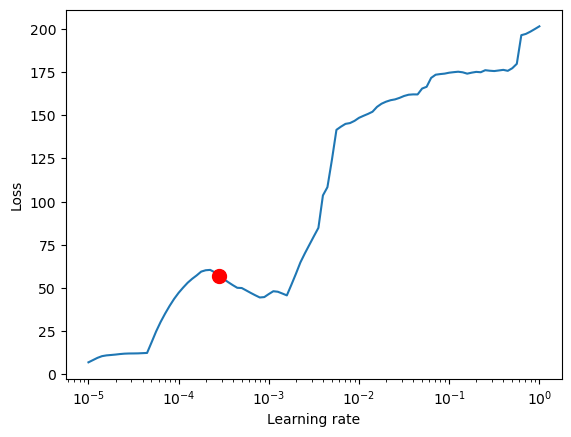

/var/folders/ct/kvv_m0bd68s01xk476lgc7sw0000gn/T/ipykernel_34010/3188746184.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [76]:
# Use learning rate finder to optimize training speed and stability
res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dl,
    val_dataloaders=val_dl,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,  # Stop early if loss spikes
)
# Print and apply the suggested learning rate
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()


### **Why this step is important**:  
- Choosing the correct learning rate is critical to DeepAR’s convergence.  
- Learning rate tuning prevents instability (too high) or slow training (too low).  
- `MultivariateNormalDistributionLoss` supports probabilistic outputs, allowing the model to estimate uncertainty, which is useful for forecasting volatile transaction fees.
---

## 5. Train DeepAR Model with Early Stopping

This section configures the training process using PyTorch Lightning. We apply early stopping to halt training when validation loss plateaus, preventing overfitting and saving compute resources. We then train the DeepAR model using the tuned configuration and prepared dataloaders.


In [78]:
# Set early stopping to monitor validation loss and stop if no improvement
early_stop_callback = EarlyStopping(
    monitor="val_loss",  # Watch validation loss
    min_delta=1e-4,  # Minimum improvement threshold
    patience=10,  # Stop after 10 epochs without improvement
    verbose=False,
    mode="min",  # We want to minimize the loss
)
# Configure PyTorch Lightning trainer
trainer = pl.Trainer(
    max_epochs=30,  # Maximum number of training epochs
    accelerator="cpu",  # Run on CPU
    enable_model_summary=True,  # Print model architecture
    gradient_clip_val=0.1,  # Prevent exploding gradients
    callbacks=[early_stop_callback],
    enable_checkpointing=True,  # Save best model
)
# Initialize DeepAR model
net = DeepAR.from_dataset(
    training,
    learning_rate=0.0003,  # Learning rate tuned via lr_finder
    hidden_size=30,  # RNN hidden units, recommended by pytorch tutorial
    rnn_layers=2,  # RNN depth, recommended by pytorch tutorial
    loss=MultivariateNormalDistributionLoss(
        rank=30
    ),  # Probabilistic loss with covariance structure
    optimizer="Adam",
)
# Train the model
trainer.fit(
    net,
    train_dataloaders=train_dl,
    val_dataloaders=val_dl,
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                   | Type                               | Params | Mode 
--------------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0      | train
1 | logging_metrics        | ModuleList                         | 0      | train
2 | embeddings             | MultiEmbedding                     | 20     | train
3 | rnn                    | LSTM                               | 13.0 K | train
4 | distribution_projector | Linear                             | 992    | train
--------------------------------------------------------------------------------------
14.0 K    Trainable params
0         Non-trainable params
14.0 K    Total params
0.056     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|█| 220/220 [09:09<00:00,  0.40it/s, v_num=5, train_loss_step=-324.
idation: |                                             | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████████████████████| 1/1 [00:00<00:00, 37.49it/s]
Epoch 1: 100%|█| 220/220 [09:16<00:00,  0.40it/s, v_num=5, train_loss_step=-336.
idation: |                                             | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████████████████████| 1/1 [00:00<00:00, 34.88it/s]
Epoch 2: 100%|█| 220/220 [09:19<00:00,  0.39it/s, v_num=5, train_loss_step=-348.
idation: |                                             | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████████████████████| 1/1 [00:00<00:00, 35.58it/s]
Epoch 3: 100%|█| 220/220 [09:30<00:00,  0.39it/s, v_num=5, train_loss_step=-366.
idation: |                                             | 0/? [00:00<?, ?it/s]
idation DataLoader 0: 100%|████████████████████| 1/1 [00:00<00:00, 34.63it/s]
Epoch 4: 100%|█| 220/220 [10:02<00:00,  0.36it/s, v_

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|█| 220/220 [10:12<00:00,  0.36it/s, v_num=5, train_loss_step=-1.0


### **Why this step is important**:  
- Training with early stopping helps avoid overfitting and wasted computation.  
- The chosen loss function allows DeepAR to model uncertainty, crucial for forecasting Bitcoin fees.  
- Proper training orchestration ensures reproducibility and model checkpointing for later evaluation.
---

## 6. Load Best Model, Generate Predictions, and Evaluate Forecasts

After training, we load the best DeepAR model (based on validation loss), run multi-sample predictions, and evaluate its performance using custom metrics. We compute MAE, RMSE, MAPE, and a custom loss that combines MAE and standard deviation penalty to account for both accuracy and forecast uncertainty.

In [340]:
# Load the best model checkpoint (fallback to manual path if needed)
best_model_path = trainer.checkpoint_callback.best_model_path
if not best_model_path:
    best_model_path = "./saved_models/v_5-e29-s-6600.ckpt" #Last saved best model
best_model = DeepAR.load_from_checkpoint(best_model_path)


/Users/xuximin/miniforge3/envs/satcast/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/xuximin/miniforge3/envs/satcast/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [341]:
# Set seed and run raw prediction with 100 samples (for distributional output)
pl.seed_everything(42)
raw_predictions = net.predict(
    df_valid,
    mode="raw",
    return_x=True,
    n_samples=100,
    trainer_kwargs=dict(accelerator="cpu")
)

Seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/xuximin/miniforge3/envs/satcast/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/xuximin/miniforge3/envs/satcast/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


In [342]:
# Extract true values for final prediction window
df_true = df_valid[
    lambda x: (x.time_idx > x.time_idx.max() - PRED_STEPS) & (x.time_idx <= x.time_idx.max())
]
df_true.head()

,timestamp,series_id,target,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,mempool_count,mempool_vsize,...,mempool_fee_histogram_bin_250_300,time_idx,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,minute_sin,minute_cos
6408,2025-05-10 20:00:00,recommended_fee_economyFee,2.0,0.204689,0.316335,-0.676080,-0.575387,-0.360107,-0.971025,-0.835288,...,0.0,6408,-0.866025,0.500000,-0.974928,-0.222521,0.5,-0.866025,0.000000e+00,1.000000e+00
6409,2025-05-10 20:15:00,recommended_fee_economyFee,2.0,-0.018025,0.315997,0.491406,-0.130973,-0.023545,-0.787079,-0.717240,...,0.0,6409,-0.866025,0.500000,-0.974928,-0.222521,0.5,-0.866025,1.000000e+00,2.832769e-16
6410,2025-05-10 20:30:00,recommended_fee_economyFee,2.0,-0.133364,0.316343,0.562678,0.145377,0.207364,-0.651556,-0.654544,...,0.0,6410,-0.866025,0.500000,-0.974928,-0.222521,0.5,-0.866025,5.665539e-16,-1.000000e+00
6411,2025-05-10 20:45:00,recommended_fee_economyFee,2.0,0.108947,0.316256,0.753281,0.045712,0.106224,-0.603747,-0.633964,...,0.0,6411,-0.866025,0.500000,-0.974928,-0.222521,0.5,-0.866025,-1.000000e+00,-1.836970e-16
6412,2025-05-10 21:00:00,recommended_fee_economyFee,2.0,0.200985,0.316294,-0.038883,-0.086010,0.117566,-0.670968,-0.635152,...,0.0,6412,-0.707107,0.707107,-0.974928,-0.222521,0.5,-0.866025,0.000000e+00,1.000000e+00


In [343]:
# Post-process prediction tensor → median forecast
pred_np = (
    raw_predictions.output.prediction.detach().cpu().numpy()
)  # Shape: (samples, series, time)
y_pred = np.median(pred_np, axis=-1).flatten()  # Median across samples
time_idx = raw_predictions.x["decoder_time_idx"].detach().cpu().numpy().flatten()

# Merge predictions with metadata and ground truth
df_eval = pd.DataFrame(
    dict(
        timestamp=df_true["timestamp"],
        time_idx=time_idx,
        series_id=df_true["series_id"],
        y_true=df_true["target"],
        y_pred=y_pred,
    )
)

df_eval


,timestamp,time_idx,series_id,y_true,y_pred
6408,2025-05-10 20:00:00,6408,recommended_fee_economyFee,2.0,1.622574
6409,2025-05-10 20:15:00,6409,recommended_fee_economyFee,2.0,1.662363
6410,2025-05-10 20:30:00,6410,recommended_fee_economyFee,2.0,1.701109
6411,2025-05-10 20:45:00,6411,recommended_fee_economyFee,2.0,1.726439
6412,2025-05-10 21:00:00,6412,recommended_fee_economyFee,2.0,1.755670
...,...,...,...,...,...
32899,2025-05-11 18:45:00,6499,recommended_fee_minimumFee,1.0,0.970074
32900,2025-05-11 19:00:00,6500,recommended_fee_minimumFee,1.0,0.974037
32901,2025-05-11 19:15:00,6501,recommended_fee_minimumFee,1.0,0.995223
32902,2025-05-11 19:30:00,6502,recommended_fee_minimumFee,1.0,1.009469


In [344]:
# Compute evaluation metrics per series
metrics_per_sid = (
    df_eval.groupby("series_id")
    .apply(
        lambda g: pd.Series(
            {
                "MAE": np.abs(g.y_pred - g.y_true).mean(),
                "STD Penalty": np.abs(np.std(g.y_pred) - np.std(g.y_true)),
                "MAE + STD Penalty": np.abs(g.y_pred - g.y_true).mean()
                + 1 * np.abs(np.std(g.y_pred) - np.std(g.y_true)),  # Add variance penalty
                "RMSE": np.sqrt(((g.y_pred - g.y_true) ** 2).mean()),
                "MAPE": (np.abs((g.y_pred - g.y_true) / g.y_true).mean()),
            }
        )
    )
    .reset_index()
    .sort_values("MAE + STD Penalty")  # Sort by custom objective
)
metrics_per_sid

/var/folders/ct/kvv_m0bd68s01xk476lgc7sw0000gn/T/ipykernel_34010/1151998953.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


,series_id,MAE,STD Penalty,MAE + STD Penalty,RMSE,MAPE
4,recommended_fee_minimumFee,0.017166,0.015808,0.032974,0.021160,0.017166
0,recommended_fee_economyFee,0.456279,0.419186,0.875465,0.499401,0.376496
2,recommended_fee_halfHourFee,0.764418,0.598202,1.362620,0.925683,0.521861
3,recommended_fee_hourFee,0.834044,0.573416,1.407460,0.952933,0.654982
1,recommended_fee_fastestFee,0.858501,0.679593,1.538093,1.069831,0.448755


### **Why this step is important**:  
- Ensures evaluation is based on the best-performing model checkpoint.  
- Median over samples provides robust point forecasts from probabilistic DeepAR output.  
- Custom metric with MAE + STD penalty balances accuracy with stability, rewarding consistent yet sharp forecasts — critical for volatile series like Bitcoin fees.
---

## 7. Visualize Forecasts: Actual vs. Predicted per Series

To qualitatively assess DeepAR’s performance, we visualize the predicted vs. actual transaction fees for multiple series. This helps validate that the model not only fits metrics but also captures spike timing, magnitude, and variance across time.


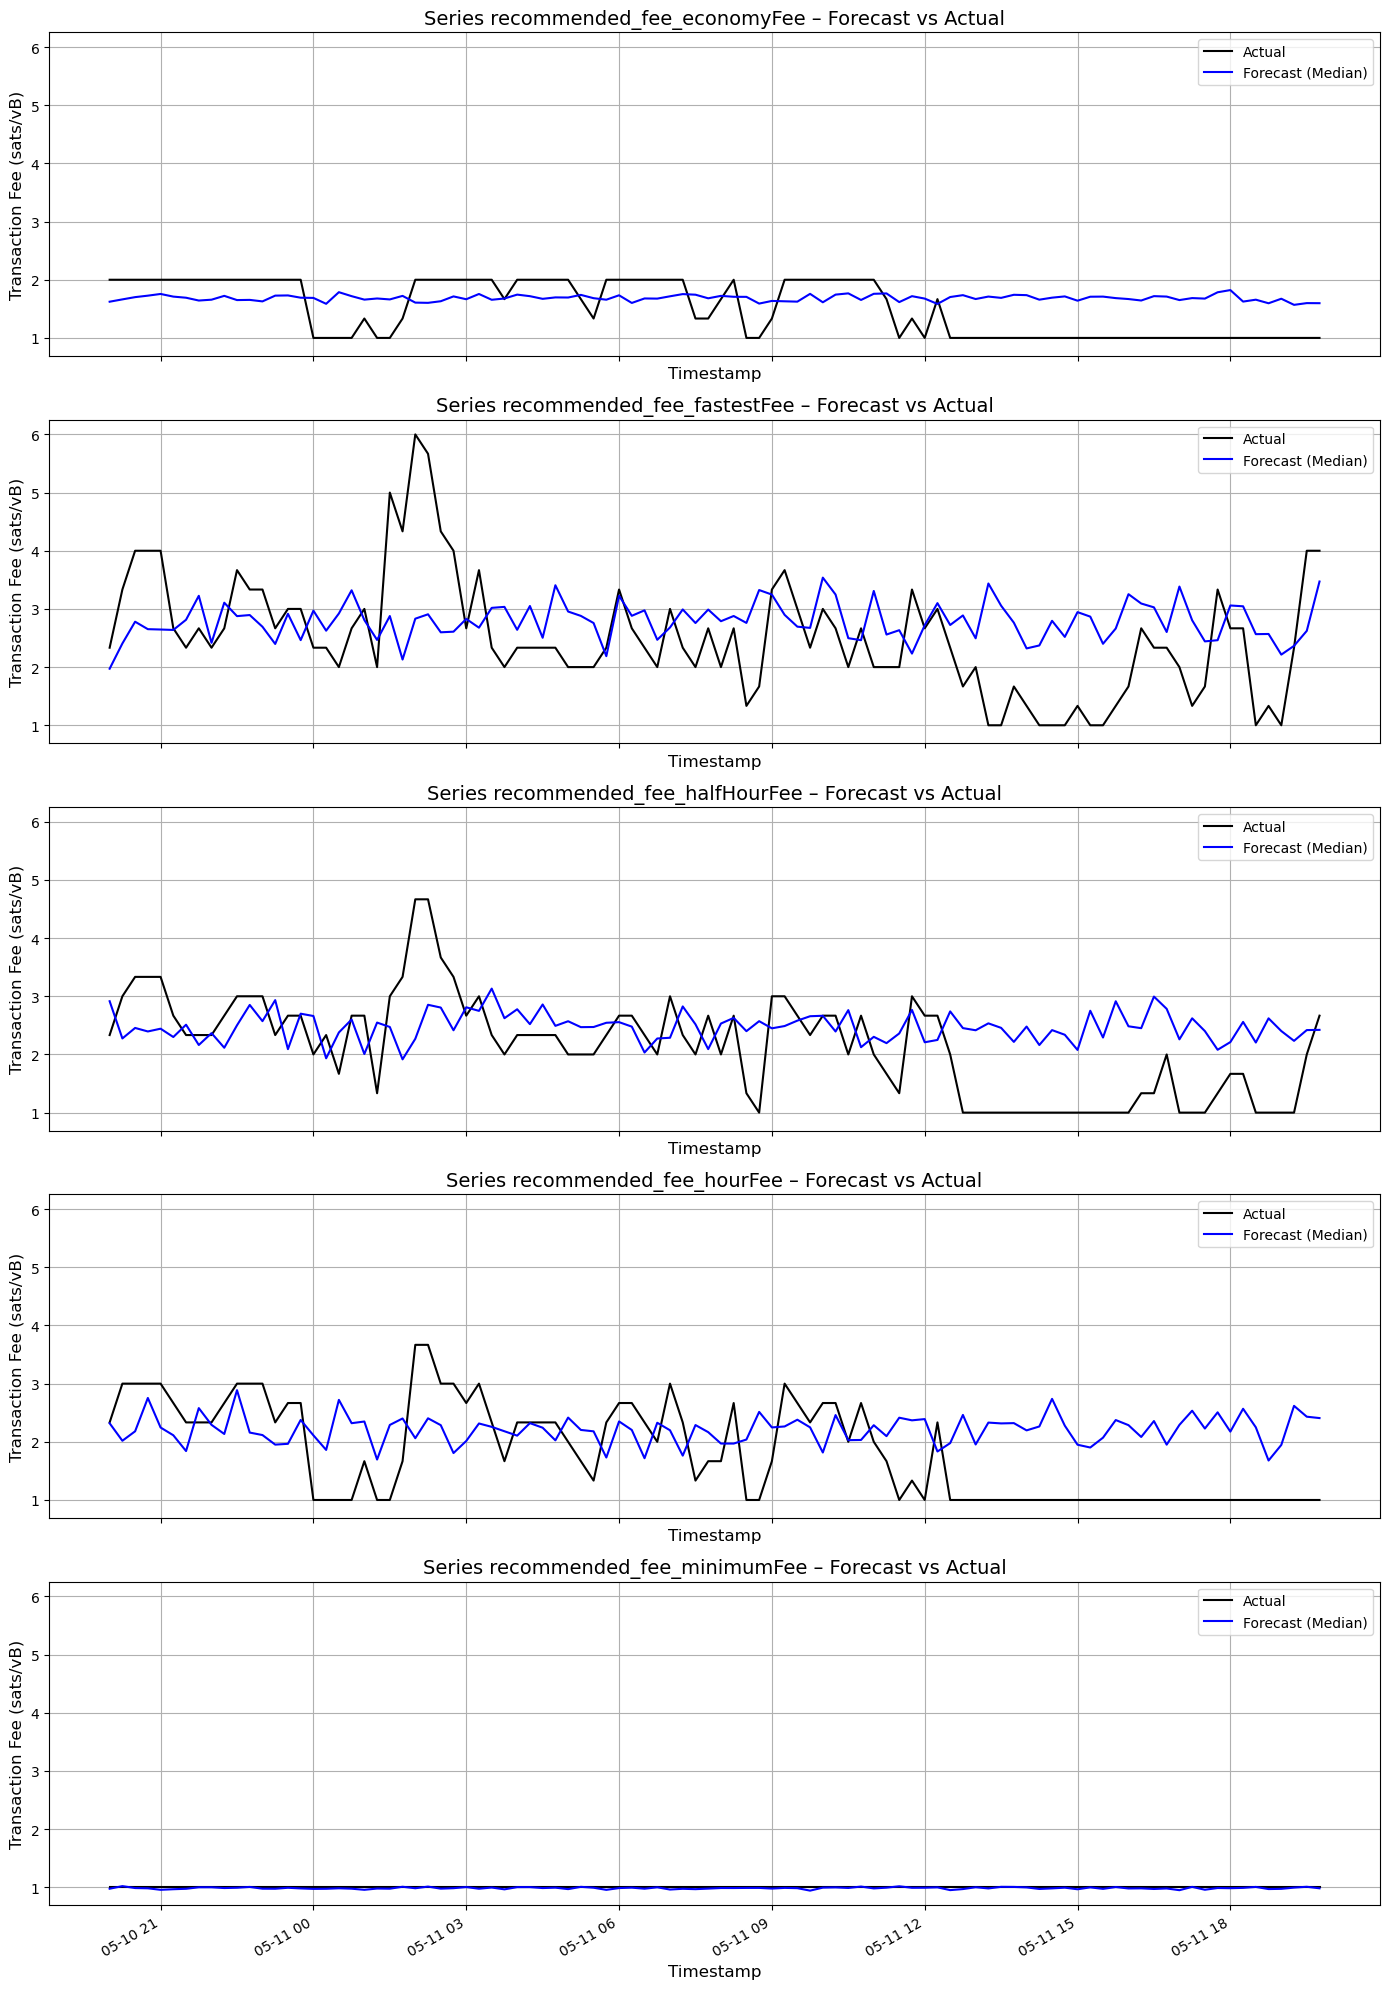

In [348]:
from plot_metrics_series import plot_series
fig, axs = plt.subplots(5, 1, figsize=(14, 20), sharex=True, sharey=True)

# Loop over 5 unique series_ids and corresponding axes
for i, sid in enumerate(df_eval.series_id.unique()[:5]):
    plot_series(df_eval, sid, ax=axs[i])  # pass df_eval explicitly

plt.tight_layout()
plt.show()

### **Why this step is important**:  
- Visual checks can reveal issues missed by aggregate metrics, such as lagging predictions, missed spikes, or unstable noise.  
- Ensures model predictions are interpretable and aligned with expected fee dynamics — essential for operational deployment in real-time Bitcoin fee estimation.